In [51]:
%load_ext autoreload

%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import torch

sys.path.append('..')

from torch import nn
from Utils.NeuralNetworks import SigmoidNeuralNetwork
from Utils.utils import load_data, run_multiple_nn, run_multiple_forest, run_multiple_logistics
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define Paramaters

In [52]:
base_seed = 42
base_feature_size = 24
baseline_accuracy = 0.8

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


# Neural Network

In [53]:
X_train, y_train, _, _, feature_size  = load_data(base_seed, base_feature_size, discreteize=True, expand=False)
print(X_train.shape)

(38400, 48)


### Performing grid search

In [54]:
net = NeuralNetClassifier(
    module=SigmoidNeuralNetwork,
    max_epochs=50,
    criterion=nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=0.01,
    batch_size=2048,
    module__input_size=feature_size,
    device=device,
    train_split=None
)

params = {
    'optimizer__lr': [0.1],
    'max_epochs': [100],
    'batch_size': [4096],
    'module__layer_size': [256],
    'module__layer_no': [2],
    'optimizer__weight_decay': [1e-3],
}

gs = GridSearchCV(net, params, refit=False, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)
clf = gs.fit(X_train, y_train.astype(float))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


In [55]:
print("Best parameters found: ", gs.best_params_)
print("Best accuracy found: ", gs.best_score_)

Best parameters found:  {'batch_size': 4096, 'max_epochs': 100, 'module__layer_no': 2, 'module__layer_size': 256, 'optimizer__lr': 0.1, 'optimizer__weight_decay': 0.001}
Best accuracy found:  0.5006510416666666


### Assesing performance

In [56]:
nn_results = run_multiple_nn(gs, base_feature_size=base_feature_size, device=device, no_runs=1)

Run 1 / 1 started
Run finished with test accuracy: 0.5016666666666667


In [57]:
print(nn_results.head())

os.makedirs('results', exist_ok=True)
nn_results.to_csv(f'results/nn_results_{base_feature_size}.csv')

   Seed  epoch  train_loss  train_accuracy  test_accuracy
0     0      0    7.065909        0.500052       0.501667
1     0      1    0.993306        0.499063       0.501667
2     0      2    0.757467        0.499010       0.501667
3     0      3    0.713364        0.503073       0.501667
4     0      4    0.697848        0.508880       0.501667


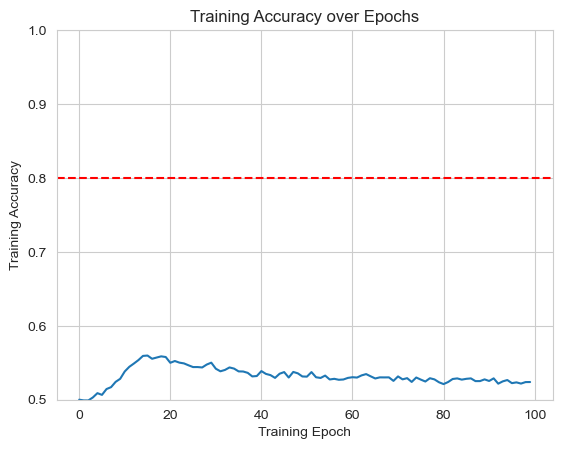

In [63]:
sns.set_style("whitegrid")
ax = sns.lineplot(data=nn_results, x='epoch', y='train_accuracy', errorbar='sd')
ax.set(xlabel='Training Epoch', ylabel='Training Accuracy', ylim=(0.5, 1.0), title='Training Accuracy over Epochs')
plt.axhline(y=baseline_accuracy, color='r', linestyle='--')
plt.show()

# Random Forrests

In [59]:
X_train, y_train, _, _, feature_size  = load_data(base_seed, base_feature_size, discreteize=True, expand=True)

MemoryError: Unable to allocate 7.22 TiB for an array with shape (38400, 25827165) and data type float64

### Assessing Performance

In [ ]:
forrest_results = run_multiple_forest(base_feature_size, no_runs=10)

Run 1 / 10 started


In [ ]:
print(forrest_results)

os.makedirs('results', exist_ok=True)
forrest_results.to_csv(f'results/rf_results_{base_feature_size}.csv')

   run  test_accuracy
0    0       0.965000
1    1       0.969667
2    2       0.967000
3    3       0.967667
4    4       0.962000
5    5       0.965833
6    6       0.966667
7    7       0.966667
8    8       0.965833
9    9       0.968333


In [ ]:
print("Random Forest Accuracy:", forrest_results['test_accuracy'].mean())
print("Baseline to beat", baseline_accuracy)

Random Forest Accuracy: 0.9664666666666667
Baseline to beat 0.9
